## Set random seed

In [37]:
import torch
torch.manual_seed(42)

## Preprocess

In [38]:
def preprocess(path, max_len = None, testing = False):
    dataset = []
    with open(path, 'r', encoding='UTF-8') as f:
        for line in f:
            line = line.strip()
            if testing:
                dataset.append([word for word in line])
            else:
                dataset.append(['<SOS>'] + [word for word in line[:max_len]] + ['<EOS>'])
    return dataset

In [39]:
max_len = 25
dataset = preprocess('hw2.1_corpus.txt', max_len)
testDataset = preprocess('hw2.1-2_sample_testing_data.txt', testing=True)

In [40]:
class Word_dict():
    def __init__(self, dataset, max_len):
        self.word_dict = {}
        self.idx_dict = {}
        self.add("<PAD>")
        for i in range(1, max_len - 1):
            self.add(str(i))
        self.add("<UNK>")

        self.make_dict(dataset)
        
    def make_dict(self, dataset):
        for sent in dataset:
            for word in sent:
                self.add(word)
        
    def add(self, word):
        if word not in self.word_dict:
            self.idx_dict[self.get_len()] = word
            self.word_dict[word] = self.get_len()
            
            
    def word2index(self, word):
        if word in self.word_dict:
            return self.word_dict[word]
        else:
            return self.word_dict["<UNK>"]
    
    def idx2word(self, idx):
        return self.idx_dict[idx]
    
    def get_len(self):
        return len(self.word_dict)

In [41]:
word_dict = Word_dict(dataset, max_len)
PAD_IDX = word_dict.word2index("<PAD>")
import pickle

with open('dicitonary.pkl','wb') as f:
    pickle.dump(word_dict, f)

In [42]:
def data2index(sent):
    return [word_dict.word2index(word) for word in sent]

def process_training_data(dataset):
    datas = []
    for idx in range(len(dataset)-1):
        processed = {}
        processed['x'] = data2index(dataset[idx])
        processed['y'] = data2index(dataset[idx+1])
        datas.append(processed)
    return datas

def process_testing_data(dataset):
    datas = []
    for data in dataset:
        datas.append(data2index(data))
    return datas

In [43]:
from sklearn.model_selection import train_test_split

data = process_training_data(dataset)
trainData, validData = train_test_split(data, test_size=0.2, random_state=42)

testData = process_testing_data(testDataset)

In [44]:
from sklearn.model_selection import train_test_split
trainData, validData = train_test_split(data, test_size=0.2, random_state=42)

In [45]:
import random
random.seed(42)

In [46]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch

class SentenceDataset(Dataset):
    def __init__(self, data, pad_idx, ncontrols = 1, training = True):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
        self.training = training
        self.ncontrols = ncontrols
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        if self.training:
            processed_data = []
            for data in datas:
                self.process_data(data)
                processed_data.append(data)
            processed_data.sort(key=lambda x : len(x['x']), reverse=True)
            batch_data = [data['x'] for data in processed_data]
            
            datas_len = [len(data) for data in batch_data]
            batch_data = self.make_padding(batch_data)
            
            batch_label = [data['y'] for data in processed_data]
            batch_label = self.make_padding(batch_label)
            batch_random_num = [data['random_num'] for data in processed_data]
                        
            return torch.LongTensor(batch_data), torch.LongTensor(batch_label), torch.LongTensor(datas_len), batch_random_num
        
        else:
            datas_idx = sorted(range(len(datas)), key=lambda x : datas[x])
            datas.sort(key=lambda x: len(x), reverse=True)
            datas_len = [len(sent) for sent in datas]
            batch_data = self.make_padding(datas)
            return torch.LongTensor(batch_data), torch.LongTensor(datas_len), datas_idx
    
    def process_data(self, data):
        data['random_num'] = self.get_ncontrols(len(data['y'])-2)
        data['x'] = self.add_control(data['x'], data['y'], data['random_num'])
    
    def get_ncontrols(self, sent_len):
        sample_num = random.randint(1, self.ncontrols)
        if sent_len < sample_num:
            sample_num = sent_len
            
        samples = random.sample([i for i in range(1, sent_len+1)], sample_num)
        samples.sort()
        return samples
    
    def add_control(self, data, label, samples):
        for sample in samples:
            data = data + [word_dict.word2index(str(sample))] + [label[sample]]
        return data
    
    def make_padding(self, datas):
        max_len = max([len(data) for data in datas])
        return [data + [self.pad_idx]*(max_len-len(data)) for data in datas]

In [47]:
trainData = SentenceDataset(trainData, PAD_IDX, 2)
validData = SentenceDataset(validData, PAD_IDX, 2)
testData = SentenceDataset(testData, PAD_IDX, training = False)

## Model

In [48]:
from torch import nn

In [49]:
class Embedding(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(Embedding, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
    def forward(self, input):
        embedded = self.embedding(input)
        
        return embedded

In [50]:
from torch.nn.utils.rnn import pack_padded_sequence
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, embedding):
        super(Encoder, self).__init__()
        
        self.embedding = embedding
    
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)        
    
    def forward(self, input, data_len):
        input = self.embedding(input)
        
        pack_datas = pack_padded_sequence(input, data_len, batch_first=True)
        
        outputs, hidden = self.rnn(input)
        
        return hidden

In [51]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, embedding):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        
        self.embedding = embedding
        
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)

        self.out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden):
        input = self.embedding(input)
        
        output, hidden = self.rnn(input, hidden)
        
        prediction = self.out(output)
        
        return prediction, hidden

In [63]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg = None, data_len = None, teacher_forcing_ratio = 0.5, training = True):
        batch_size = src.shape[0]
        if training:
            max_len = trg.shape[1]
        else:
            max_len = 25
        
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, max_len-1, trg_vocab_size).to(device)
        
        hidden = self.encoder(src, data_len)
        
        input = src[:, 0:1]
        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:,t-1:t] = output
            
            top1 = output.argmax(2)
            
            if torch.rand(1) > teacher_forcing_ratio:
                input = top1
            else:
                input = trg[:,t:t+1]
        return outputs

## Train

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
INPUT_DIM = word_dict.get_len()
OUTPUT_DIM = word_dict.get_len()
EMB_DIM = 128
HID_DIM = 128

emb = Embedding(INPUT_DIM, EMB_DIM)
enc = Encoder(EMB_DIM, HID_DIM, emb)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, emb)

model = Seq2Seq(enc, dec).to(device)

In [66]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(
      (embedding): Embedding(6581, 128)
    )
    (rnn): GRU(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(
      (embedding): Embedding(6581, 128)
    )
    (rnn): GRU(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=6581, bias=True)
  )
)


In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,889,461 trainable parameters


In [68]:
class accuracy():
    def __init__(self):
        self.ncontrol_word = 0
        self.nword_correct = 0
    def update(self, predictions, groundTruths, random_nums):
        predictions = predictions.cpu()
        groundTruths = groundTruths.cpu()
        for i in range(len(groundTruths)):
            length = int(torch.sum(groundTruths[i] != PAD_IDX))
            prediction = predictions[i][:length]
            groundTruth = groundTruths[i][:length]
            random_num = random_nums[i]
            self.ncontrol_word += len(random_num)
            for num in random_num:
                if prediction[num] == groundTruth[num]:
                    self.nword_correct += 1
            
    
    def get_word_score(self):
        return self.nword_correct / self.ncontrol_word
    
    def print_word_score(self):
        score = self.get_word_score()
        return '{:.5f}'.format(score)

In [58]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import json

def run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    
    dataloader = DataLoader(dataset = dataset,
                            batch_size = batch_size,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    acc = accuracy()
    for i, (x, y, data_len, random_num) in trange:
        output, sent_loss = run_iter(x, y, data_len, random_num, training)
        batch_loss = sent_loss
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()
        loss += batch_loss.item()
        acc.update(output, y, random_num)
        trange.set_postfix(loss = loss / (i + 1), acc = acc.print_score())
    if training:
        history['train'].append({'acc':acc.get_word_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'acc':acc.get_word_score(), 'loss':loss/ len(trange)})
def run_iter(x, y, data_len, random_nums, training):
    x = x.to(device)
    y = y.to(device)
    if training:
        output = model(x, y, data_len)
    else:
        with torch.no_grad():
            output = model(x, y, data_len, 0)
    sent = y[:, 1:]
    sent = sent.reshape(sent.shape[0] * sent.shape[1])
    output_sent = output.view(output.shape[0] * output.shape[1], output.shape[2])
    sent_loss = criterion(output_sent, sent)
        
    return output.argmax(2), sent_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [59]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 10, gamma = 0.5)
max_epoch = 50
batch_size = 32
history = {'train':[],'valid':[]}

In [30]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
#     run_epoch(epoch, True)
    run_epoch(epoch, False)
    scheduler.step()
    save(epoch)

Epoch: 0


KeyboardInterrupt: 

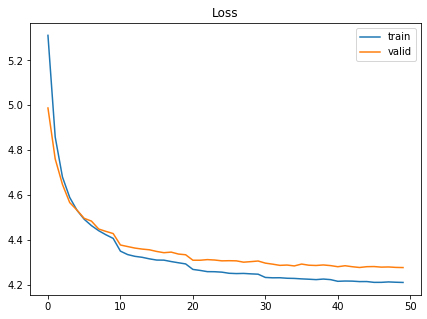

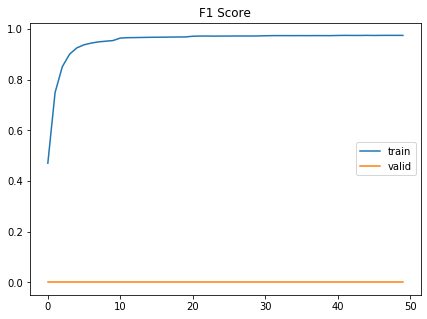

Best F1 score  [0.0, 49]


In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['word_acc'] for l in history['train']]
valid_f1 = [l['acc'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['acc'], idx] for idx, l in enumerate(history['valid'])]))

In [69]:
model.load_state_dict(torch.load('model/model.pkl.{}'.format(-1)))
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=0)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
true = []
random_nums = []
for i, (x, data_len, datas_idx) in trange:
    o_labels = model(x.to(device), data_len = data_len,teacher_forcing_ratio = 0.0, training = False)
    o_labels = torch.argmax(o_labels, dim = 2)
    o_labels = o_labels.to('cpu').numpy().tolist()
    for idx in datas_idx:
        prediction.append(o_labels[idx])


In [70]:
with open('task2-2.txt', 'w', encoding="utf-8") as f:
    for idx, sent in enumerate(prediction):
        s = ' '
        seq = ["<SOS>"] + [word_dict.idx2word(word_idx) for word_idx in sent]
        f.writelines(s.join(seq) + '\n')

[812, 6254, 812, 2142, 4727, 929, 6526, 980, 2639, 4229, 1540, 6263, 2782, 784, 2895, 2895, 2895, 2895, 2895, 2895, 2895, 2895, 2895, 2895]
['<SOS>', '平', '檠', '平', '质', '蟑', '呜', '髀', '屡', '咽', '纽', '萝', '脹', '阱', '瓜', '桨', '桨', '桨', '桨', '桨', '桨', '桨', '桨', '桨', '桨']
[3098, 2449, 6283, 3930, 6128, 4635, 2392, 6338, 2979, 2392, 2932, 4778, 2932, 3969, 4295, 125, 6352, 4145, 3715, 1431, 3262, 5006, 1197, 4104]
['<SOS>', '婪', '盾', '钤', '罟', '貪', '娄', '官', '脍', '涡', '官', '赴', '堅', '赴', '蛟', '洮', '否', '簦', '璞', '豌', '抛', '婿', '驸', '广', '將']
[4065, 5634, 5947, 1237, 5996, 2199, 139, 1777, 3522, 2928, 3262, 5006, 1197, 1077, 2505, 4509, 6367, 2505, 6532, 4326, 4778, 357, 3325, 129]
['<SOS>', '歃', '廚', '闾', '形', '瘢', '绘', '集', '务', '佉', '仇', '婿', '驸', '广', '某', '薇', '婢', '駛', '薇', '捫', '疵', '堅', '抱', '婕', '转']
[3098, 2017, 868, 4509, 1077, 129, 5290, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 2047, 129, 5290, 1266, 1266, 1266, 1266, 1266, 1266]
['<SOS>', '婪', '瀑', '节', '婢', '某', '转', '唬

['<SOS>', '婪', '婪', '驿', '缉', '伟', '娄', '讼', '苏', '见', '葭', '煳', '稞', '涎', '涎', '桠', '撜', '广', '缲', '筵', '傾', '螣', '先', '屈', '艨']
[3098, 3098, 3098, 945, 3015, 2297, 945, 5290, 1782, 4339, 5437, 4894, 3331, 1037, 2736, 5300, 5773, 5256, 4966, 2736, 3647, 4966, 2199, 4966]
['<SOS>', '婪', '婪', '婪', '雪', '屎', '換', '雪', '唬', '竹', '幢', '辯', '箔', '锦', '演', '府', '涎', '淪', '棣', '讼', '府', '陰', '讼', '绘', '讼']
[722, 59, 4861, 304, 1179, 392, 392, 392, 2349, 2349, 2349, 3301, 5290, 1266, 1266, 1266, 1266, 1266, 3602, 678, 6008, 1909, 4509, 2305]
['<SOS>', '窗', '隔', '堀', '荷', '占', '障', '障', '障', '杆', '杆', '杆', '歷', '唬', '偎', '偎', '偎', '偎', '偎', '聽', '恒', '鳔', '樂', '婢', '逕']
[3098, 1011, 36, 6165, 2584, 4573, 4573, 4989, 3625, 3304, 2736, 1739, 6485, 33, 33, 3821, 5757, 5006, 422, 33, 5395, 3495, 2658, 2753]
['<SOS>', '婪', '装', '囚', '葭', '缪', '诲', '诲', '偋', '楂', '談', '府', '恨', '扃', '思', '思', '語', '莛', '驸', '界', '思', '鲶', '邀', '炎', '莲']
[3098, 4614, 3098, 5133, 131, 3250, 5607, 1909, 2736, 5300, 3050

['<SOS>', '歃', '簪', '晏', '务', '矛', '务', '务', '矛', '务', '將', '孀', '孀', '孀', '孀', '孀', '孀', '孀', '附', '琪', '捨', '瘟', '关', '关', '关']
[4065, 5027, 2443, 269, 1088, 2044, 4234, 5396, 2250, 1443, 2991, 153, 2523, 318, 5300, 5300, 5550, 5381, 4206, 4295, 4168, 2945, 1055, 3363]
['<SOS>', '歃', '頂', '绩', '喜', '锁', '苑', '庇', '鳃', '谴', '饱', '帅', '头', '挟', '痴', '涎', '涎', '噔', '蜥', '糙', '洮', '嗣', '侥', '彷', '種']
[3098, 5882, 131, 678, 4509, 6367, 2044, 4234, 3677, 5104, 4509, 730, 730, 730, 5773, 5116, 4894, 1266, 1266, 1266, 2749, 5632, 2371, 4509]
['<SOS>', '婪', '赈', '弯', '恒', '婢', '駛', '苑', '庇', '颦', '芋', '婢', '曙', '曙', '曙', '淪', '層', '箔', '偎', '偎', '偎', '宫', '辍', '哲', '婢']
[4065, 6385, 3110, 4614, 4573, 4614, 4573, 4573, 3875, 5300, 5773, 1018, 2736, 837, 71, 1672, 5644, 3262, 4380, 1208, 695, 4966, 3677, 5536]
['<SOS>', '歃', '尐', '姿', '禹', '诲', '禹', '诲', '诲', '窦', '涎', '淪', '众', '府', '拖', '底', '溃', '玠', '婿', '弊', '竭', '脆', '讼', '颦', '鸪']
[3098, 3098, 3098, 3098, 5466, 131, 866, 5457, 5730, 2804

['<SOS>', '婪', '瀑', '节', '揹', '项', '豬', '涎', '婢', '转', '颖', '秉', '枕', '悭', '婢', '歷', '擦', '影', '薇', '婢', '駛', '霖', '柩', '项', '涎']
[3098, 3098, 3098, 4206, 1011, 5826, 5826, 5826, 1053, 3033, 135, 1208, 2151, 5859, 5300, 4412, 4104, 153, 2104, 1266, 1266, 1266, 1266, 4379]
['<SOS>', '婪', '婪', '婪', '糙', '装', '迩', '迩', '迩', '吗', '葛', '影', '竭', '堆', '迕', '涎', '诩', '將', '头', '牛', '偎', '偎', '偎', '偎', '磋']
[3098, 3098, 3098, 2890, 4635, 3785, 2932, 2710, 3304, 3620, 2523, 4341, 2395, 3937, 4681, 2349, 5010, 2523, 4698, 678, 5290, 1266, 489, 1970]
['<SOS>', '婪', '婪', '婪', '驿', '娄', '窮', '赴', '斟', '談', '儘', '挟', '晦', '熱', '烽', '偻', '杆', '秉', '挟', '罡', '恒', '唬', '偎', '诚', '献']
[3098, 6122, 131, 3250, 3710, 4885, 5300, 5300, 4667, 1730, 3331, 4455, 3304, 54, 5483, 3710, 2099, 4436, 1722, 1981, 1120, 2505, 6532, 6263]
['<SOS>', '婪', '腚', '弯', '锤', '捣', '優', '涎', '涎', '呒', '攀', '锦', '缄', '談', '依', '糌', '捣', '玄', '卵', '桠', '纪', '度', '薇', '捫', '脹']
[1007, 2894, 2213, 2394, 6124, 3915, 1183, 1107, 945